In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tvd
from riemann import shallow_roe_1D, shallow_hll_1D

plt.rcParams["figure.figsize"] = (20,9)

In [19]:
# nastavení parametrů
# constants
grav = 9.81

# domain
N = 100
Nt = 200
dx = 0.005
dt = 0.0001
dtdx = dt/dx

x_start = -N/2*dx #-5.
#x_start = 0
x = np.linspace(x_start, x_start + dx*N, N)


# problem_data
problem_data = {'grav' : grav,
               'efix' : False}

# set initial condition
def shallow_ic(N, ic_type=1):
    '''
    Initial condition type:
    
    1 ... step in half domain
    2 ... 2 steps in domain
    3 ... sinus
    '''
    
    q_state = np.zeros([2,N])
    
    if ic_type == 3:
        q_state[0,:] = .1 * np.sin(np.linspace(0,4*np.pi,N)) +1
        
    elif ic_type == 2:
        for i in range(N):
            if i < N/3:
                q_state[0,i] = 5
            elif N/3 <= i < 2*N/3:
                q_state[0,i] = 3
            else: 
                q_state[0,i] = 1
            
    else:
        q_state[0,0:int(N/2)] = 4
        q_state[0,int(N/2):] = 1

    return q_state


def shallow_sol(q_state, 
                Nt, 
                problem_data, 
                dtdx, 
                riemann_solver=shallow_roe_1D,
                higher_order = False,
                limiter = tvd.minmod,
                print_sol=False):
    
    if print_sol:
        plt.subplot(1, 2, 1)
        plt.plot(x, q_state[0,:], 'bx:')
        plt.subplot(1, 2, 2)
        plt.plot(x, q_state[1,:], 'rx:')
        plt.show()
    
    aux_l, aux_r = 0, 0
    limiters = np.full(N,limiter)
    
    for i in range(Nt):
        q_l = q_state[:,:-1]
        q_r = q_state[:,1:]

        #wave, s, amdq, apdq = shallow_roe_1D(q_l, q_r, aux_l, aux_r, problem_data)
        wave, s, amdq, apdq = riemann_solver(q_l, q_r, aux_l, aux_r, problem_data)

        q_state[:,:-1] = q_state[:,:-1] - dtdx * amdq
        #q_state[:,1:-1] = q_state[:,1:-1] - dtdx * amdq[:,1:]
        
        q_state[:,1:] = q_state[:,1:] - dtdx * apdq
        
        if higher_order:
            dtdx_array = np.full(N, dtdx)
            wave_lim = tvd.limit(2,wave,s,limiters,dtdx_array)
    
            F = np.zeros([2,N-1])
            w_num = wave.shape[1]
            for e in range(2):
                for i in range(N-1):
                    for j in range(w_num):
                        F[e,i] = 1/2 * np.abs(s[j,i])*(1-dtdx*np.abs(s[j,i]))*wave_lim[e,j,i]

            q_state[:,:-1] = q_state[:,:-1] - dtdx * F
            q_state[:,1:] = q_state[:,1:] + dtdx * F

    if print_sol:
        plt.subplot(1, 2, 1)
        plt.plot(x, q_state[0,:], 'bx:')
        plt.subplot(1, 2, 2)
        plt.plot(x, q_state[1,:], 'rx:')
        plt.show()
    
    return q_state
        
    

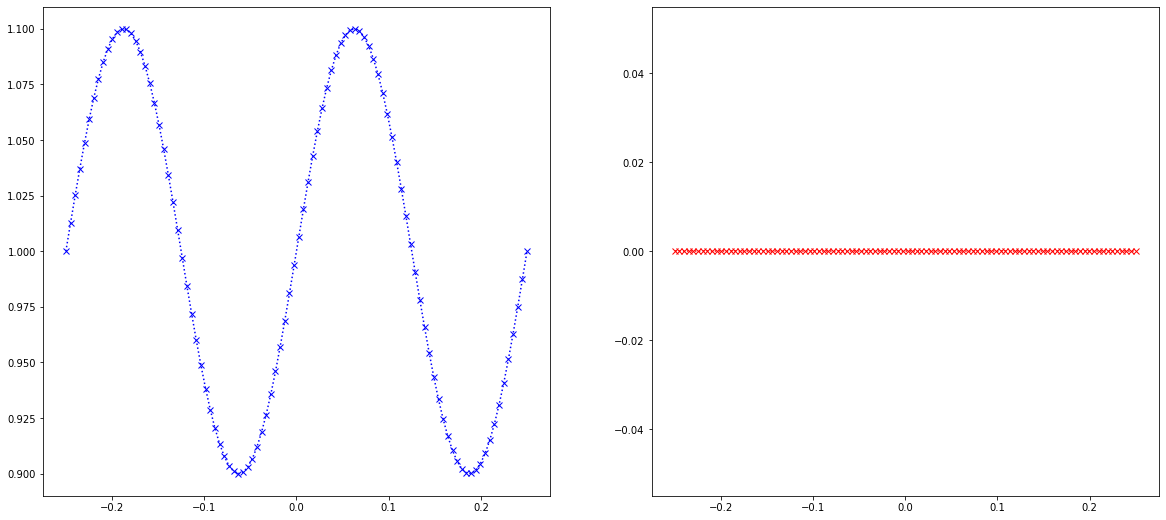

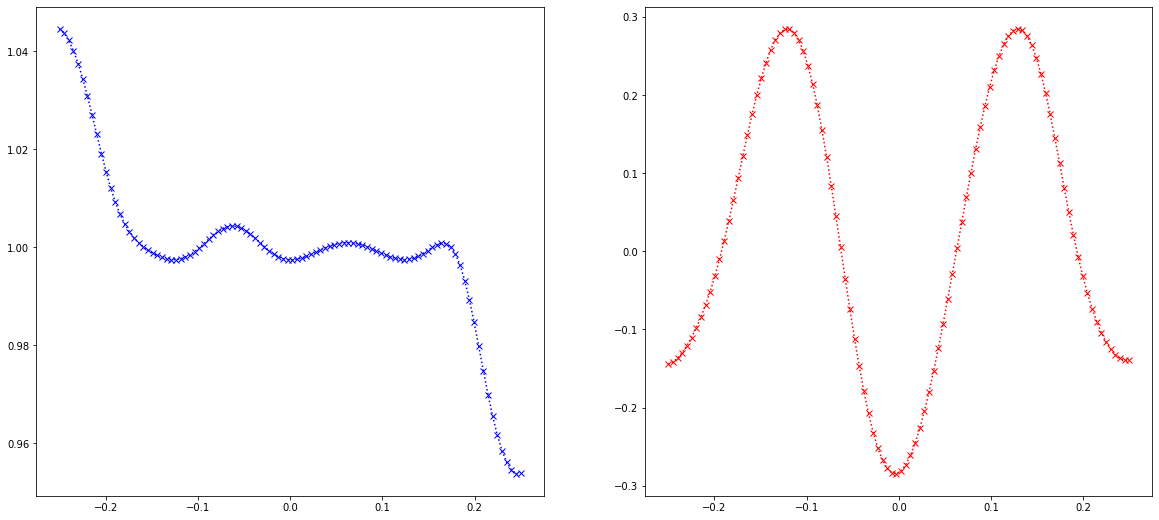

In [36]:
Q = shallow_ic(N, 3)
Q_roe = shallow_sol(Q, Nt, problem_data, dtdx, print_sol=True)

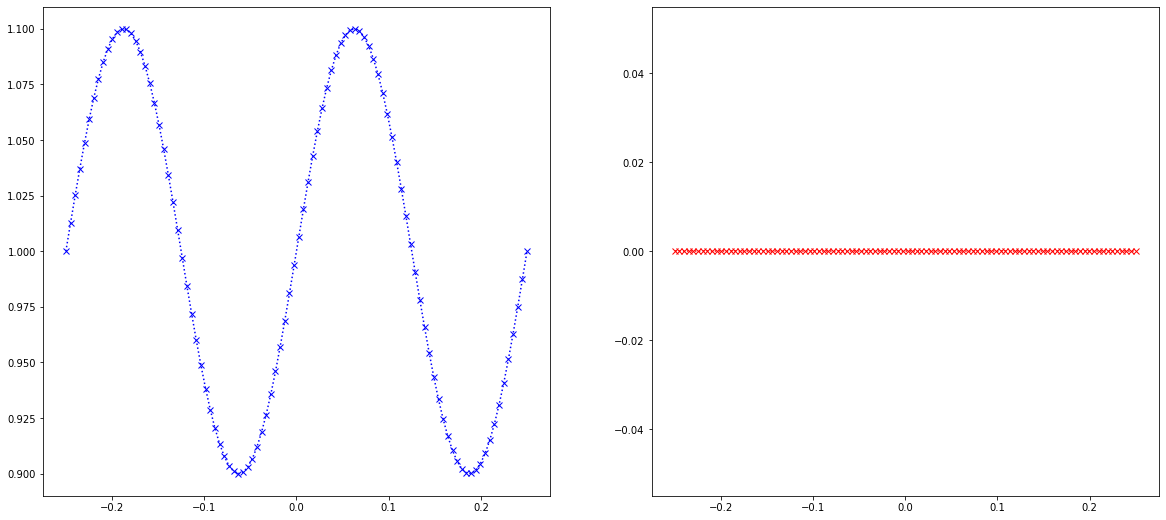

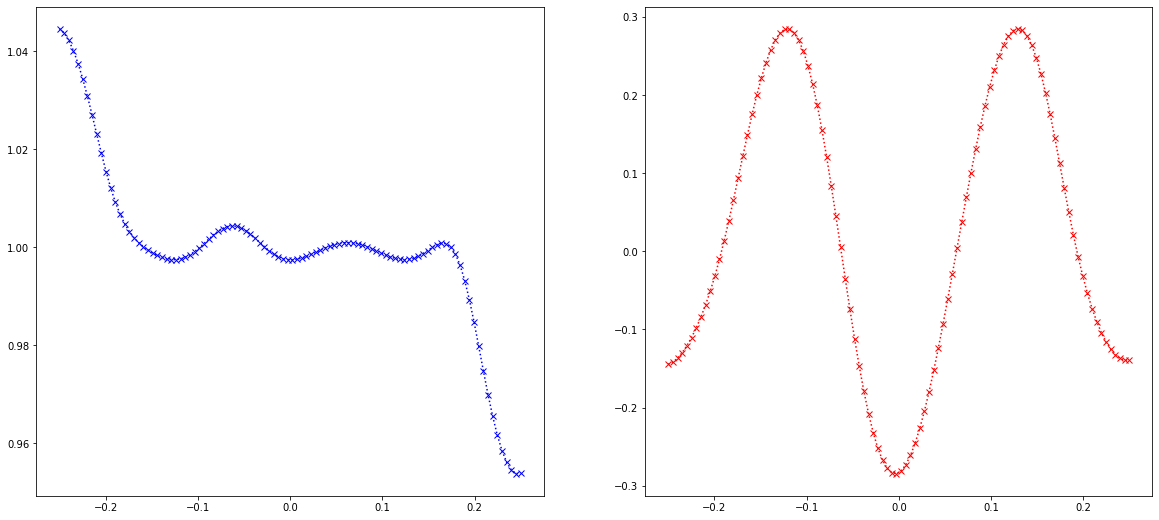

In [37]:
Q = shallow_ic(N, 3)
Q_hll = shallow_sol(Q, Nt, problem_data, dtdx, riemann_solver=shallow_hll_1D, print_sol=True)

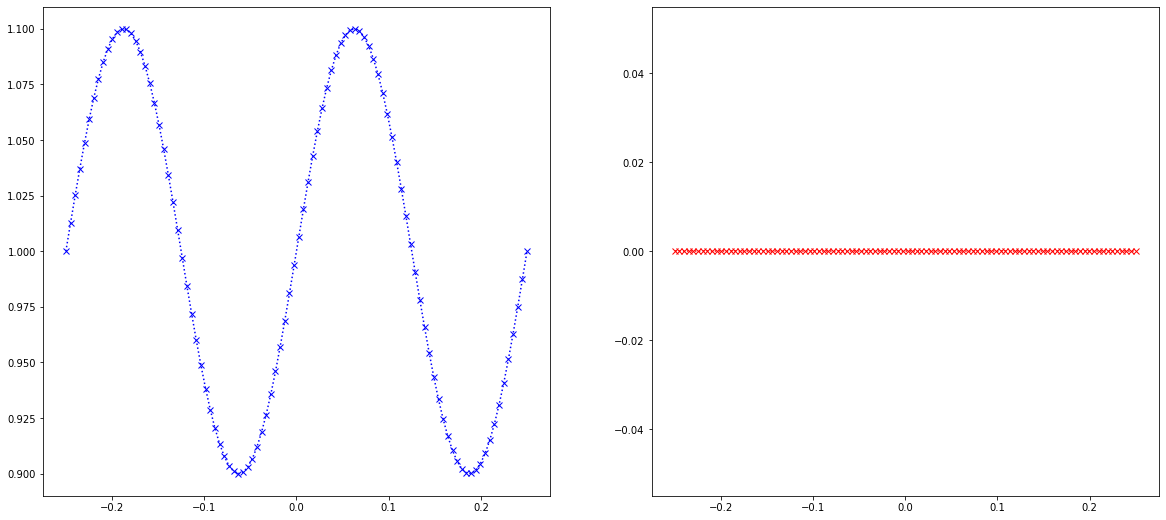

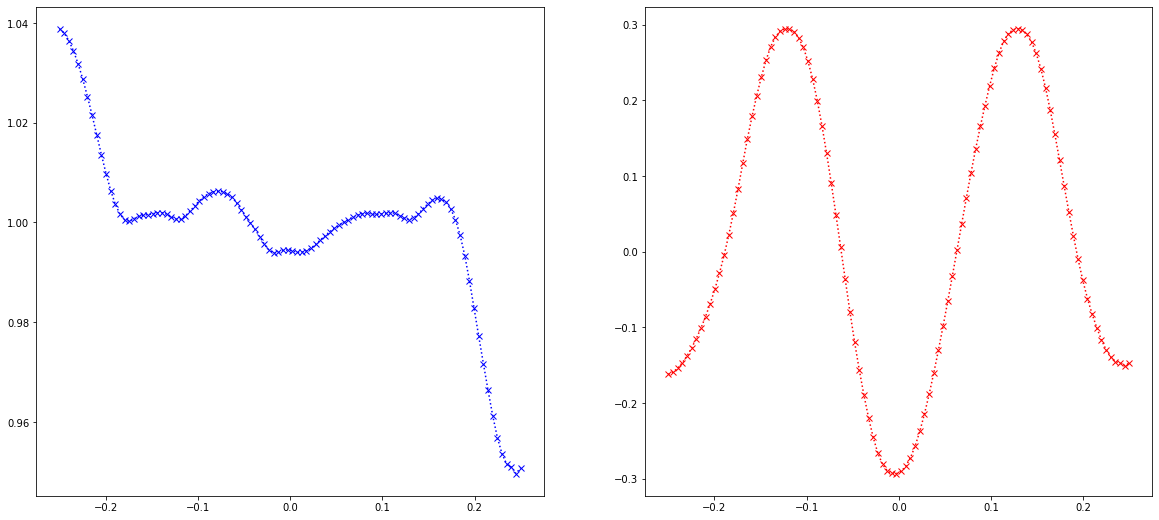

In [38]:
Q = shallow_ic(N, 3)
Q_hll_minmod = shallow_sol(Q, Nt, problem_data, dtdx, riemann_solver=shallow_hll_1D, higher_order = True, print_sol=True)
#Q_hll_arora = shallow_sol(Q, Nt, problem_data, dtdx, riemann_solver=shallow_hll_1D, higher_order = True, limiter=tvd.arora_roe, print_sol=True)

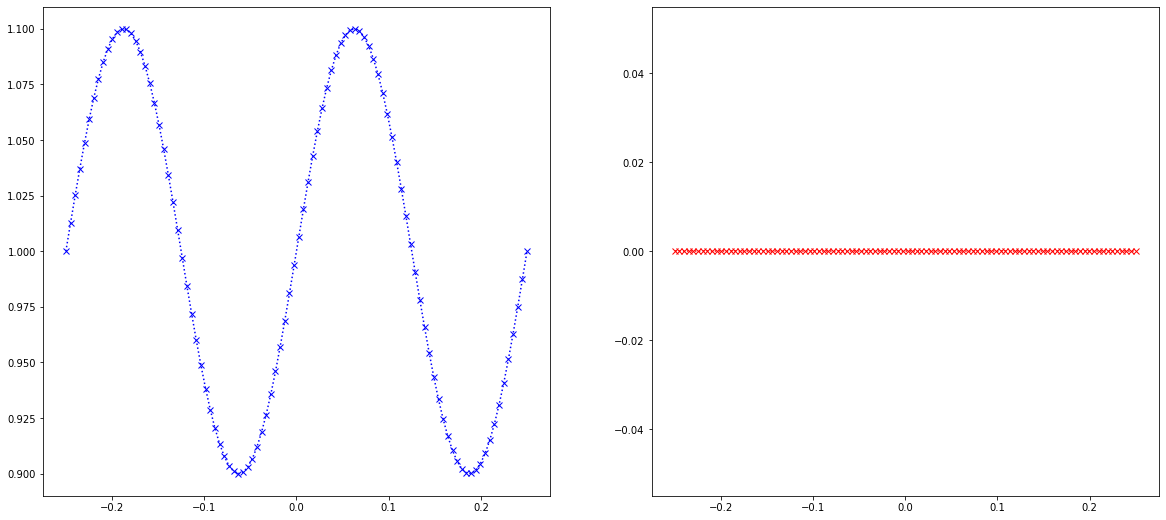

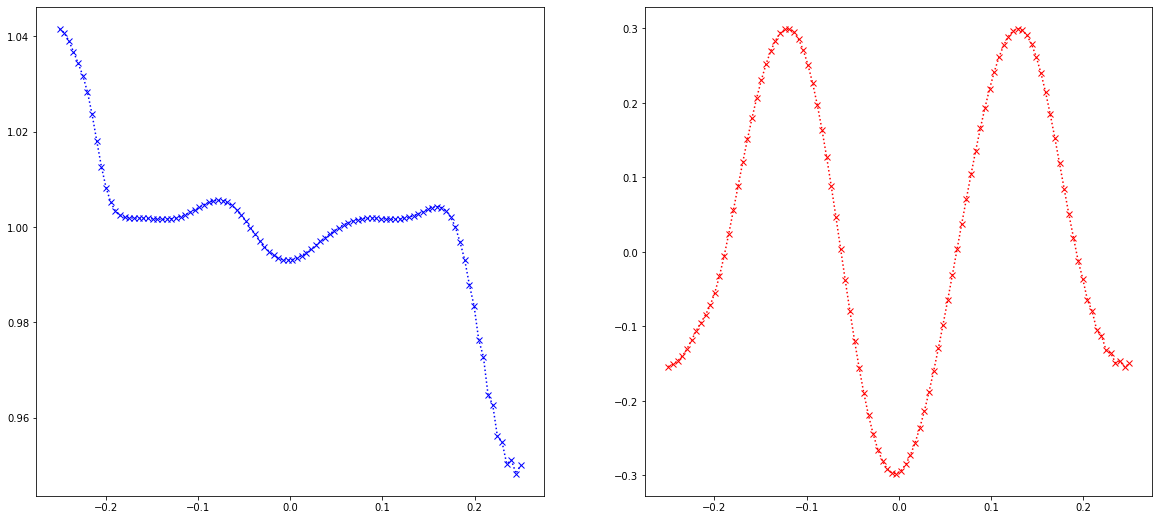

In [39]:
Q = shallow_ic(N, 3)
Q_hll_arora = shallow_sol(Q, Nt, problem_data, dtdx, riemann_solver=shallow_hll_1D, higher_order = True, limiter=tvd.arora_roe, print_sol=True)

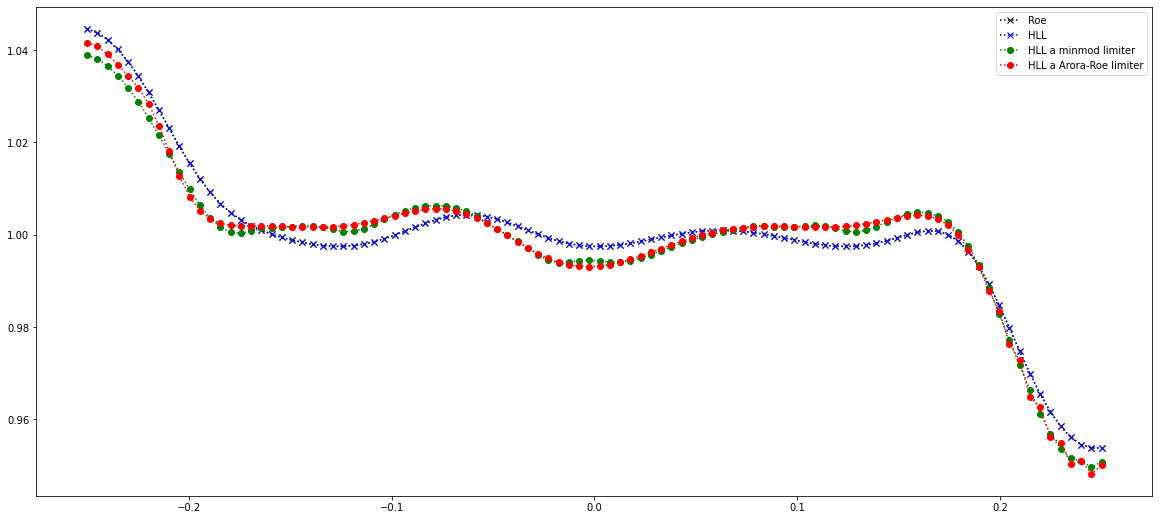

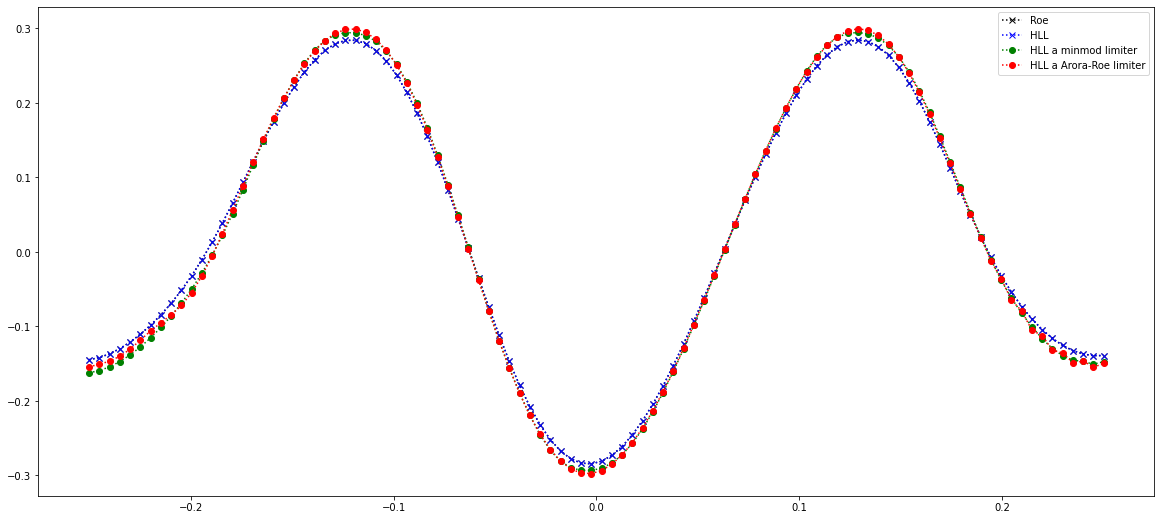

In [40]:
#plt.subplot(1, 2, 1)
plt.plot(x, Q_roe[0,:], 'kx:', label='Roe')
plt.plot(x, Q_hll[0,:], 'bx:', label='HLL')
plt.plot(x, Q_hll_minmod[0,:], 'go:', label='HLL a minmod limiter')
plt.plot(x, Q_hll_arora[0,:], 'ro:', label='HLL a Arora-Roe limiter')
plt.legend()
plt.show()
#plt.subplot(1, 2, 2)
plt.plot(x, Q_roe[1,:], 'kx:', label='Roe')
plt.plot(x, Q_hll[1,:], 'bx:', label='HLL')
plt.plot(x, Q_hll_minmod[1,:], 'go:', label='HLL a minmod limiter')
plt.plot(x, Q_hll_arora[1,:], 'ro:', label='HLL a Arora-Roe limiter')
plt.legend()
plt.show()

In [18]:
np.amax(Q_roe-Q_hll)

0.07179628790207548